<a href="https://colab.research.google.com/github/Trixie18/stock-forecasting-via-LSTM-Prophet/blob/main/Stock_Forecasting_via_LSTM_and_Prophet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [233]:
import opendatasets as od
import pandas as pd
import numpy as np

od.download("https://www.kaggle.com/datasets/camnugent/sandp500/data")

Skipping, found downloaded files in "./sandp500" (use force=True to force download)


In [234]:
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import prophet
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Dense, LSTM

# **Exploratory Data Analysis**



In [235]:
ko_df = pd.read_csv("/content/sandp500/individual_stocks_5yr/individual_stocks_5yr/KO_data.csv")
ko_df.head()

,date,open,high,low,close,volume,Name
0,2013-02-08,38.85,38.94,38.60,38.77,12308001,KO
1,2013-02-11,38.71,38.83,38.41,38.61,12159872,KO
2,2013-02-12,38.11,38.16,37.28,37.56,30700481,KO
3,2013-02-13,37.67,37.94,37.01,37.21,19942647,KO
4,2013-02-14,37.24,37.51,36.70,36.84,22748290,KO


In [236]:
goog_df = pd.read_csv("/content/sandp500/individual_stocks_5yr/individual_stocks_5yr/GOOG_data.csv")
goog_df.head()

,date,open,high,low,close,volume,Name
0,2014-03-27,568.000,568.00,552.92,558.46,13052,GOOG
1,2014-03-28,561.200,566.43,558.67,559.99,41003,GOOG
2,2014-03-31,566.890,567.00,556.93,556.97,10772,GOOG
3,2014-04-01,558.710,568.45,558.71,567.16,7932,GOOG
4,2014-04-02,565.106,604.83,562.19,567.00,146697,GOOG


In [237]:
ko_df['date'] = pd.to_datetime(ko_df['date'], format='%Y-%m-%d')
ko_df['year'] = ko_df['date'].dt.year
goog_df['date'] = pd.to_datetime(goog_df['date'], format='%Y-%m-%d')
goog_df['year'] = goog_df['date'].dt.year
print(ko_df.dtypes)
print(goog_df.dtypes)

date      datetime64[ns]
open             float64
high             float64
low              float64
close            float64
volume             int64
Name              object
year               int32
dtype: object
date      datetime64[ns]
open             float64
high             float64
low              float64
close            float64
volume             int64
Name              object
year               int32
dtype: object


**Closing Price and Volume**

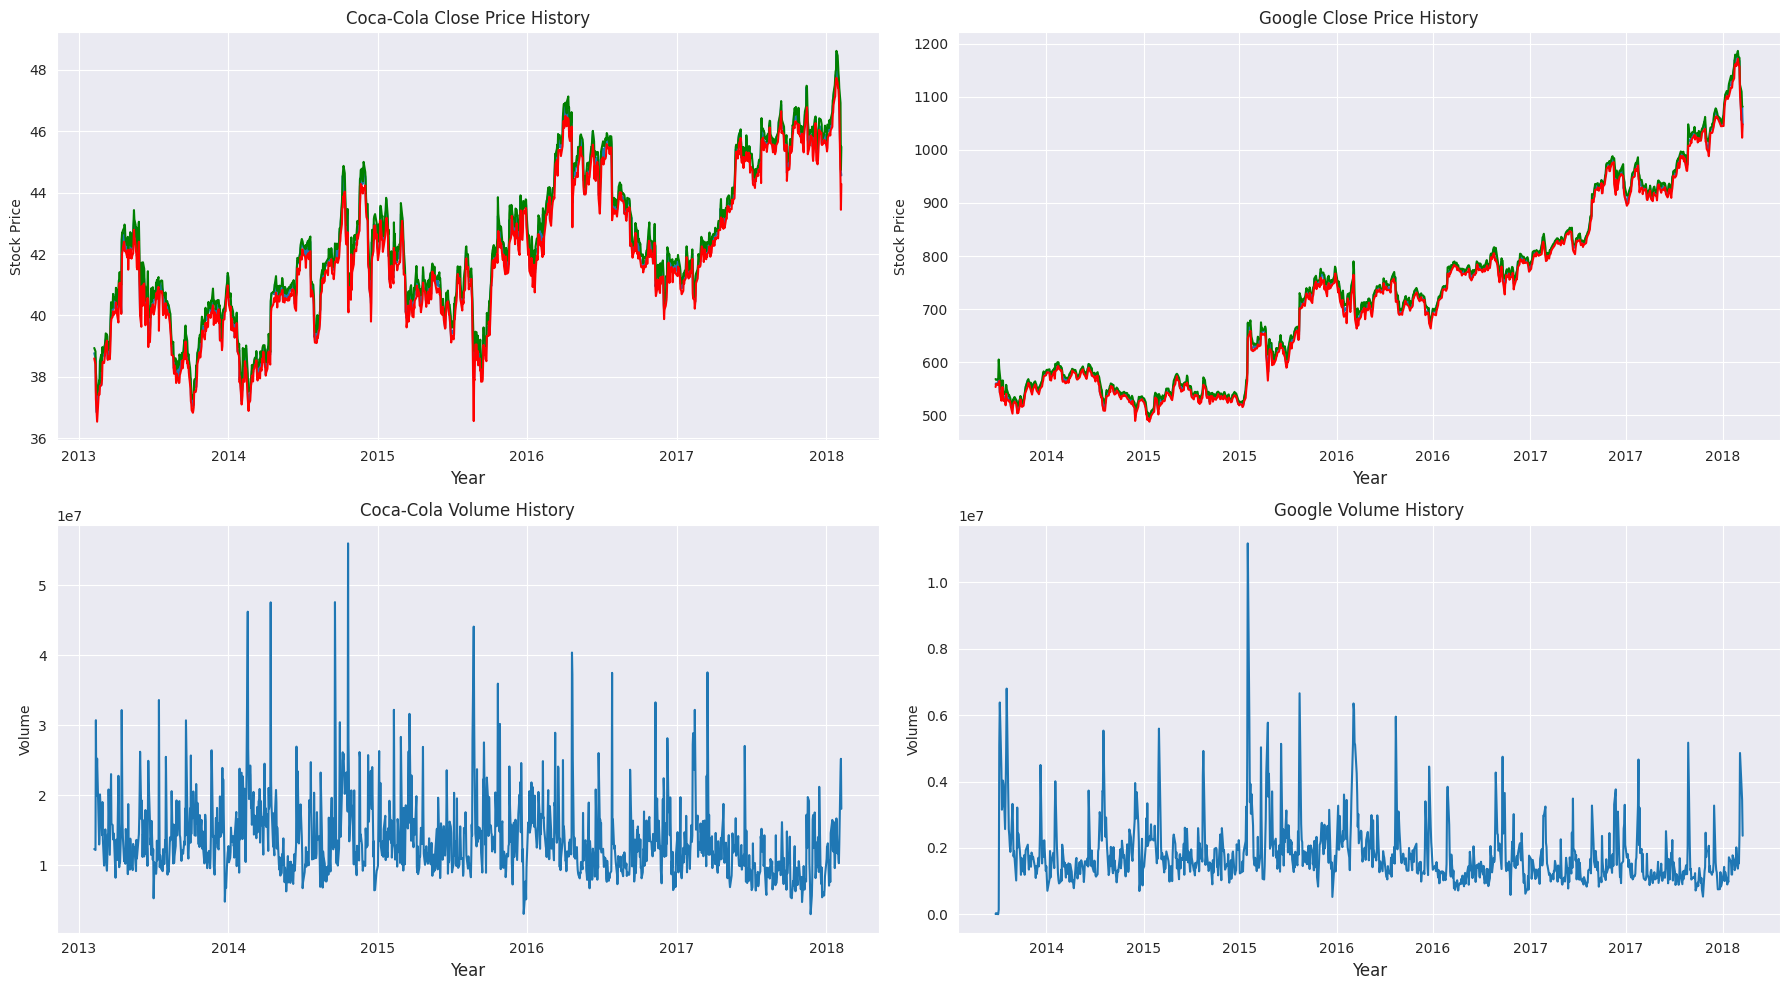

In [238]:
# Visualizations
fig, ax = plt.subplots(2, 2, figsize=(18, 10))


ax[0, 0].plot(ko_df["date"], ko_df["close"])
ax[0, 0].plot(ko_df["date"], ko_df["high"], color='green')
ax[0, 0].plot(ko_df["date"], ko_df["low"], color='red')
ax[0, 0].set_xlabel("Year", fontsize=12)
ax[0, 0].set_ylabel("Stock Price")
ax[0, 0].set_title("Coca-Cola Close Price History")
ax[0, 0].xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y'))

ax[1, 0].plot(ko_df["date"], ko_df["volume"])
ax[1, 0].set_xlabel("Year", fontsize=12)
ax[1, 0].set_ylabel("Volume")
ax[1, 0].set_title("Coca-Cola Volume History")
ax[1, 0].xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y'))

ax[0, 1].plot(goog_df['date'], goog_df['close'])
ax[0, 1].plot(goog_df['date'], goog_df['high'], color='green')
ax[0, 1].plot(goog_df['date'], goog_df['low'], color='red')
ax[0, 1].set_xlabel("Year", fontsize=12)
ax[0, 1].set_ylabel("Stock Price")
ax[0, 1].set_title("Google Close Price History")
ax[0, 1].xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y'))

ax[1, 1].plot(goog_df["date"], goog_df["volume"])
ax[1, 1].set_xlabel("Year", fontsize=12)
ax[1, 1].set_ylabel("Volume")
ax[1, 1].set_title("Google Volume History")
ax[1, 1].xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y'))

plt.tight_layout()
plt.show()

**Moving Average**

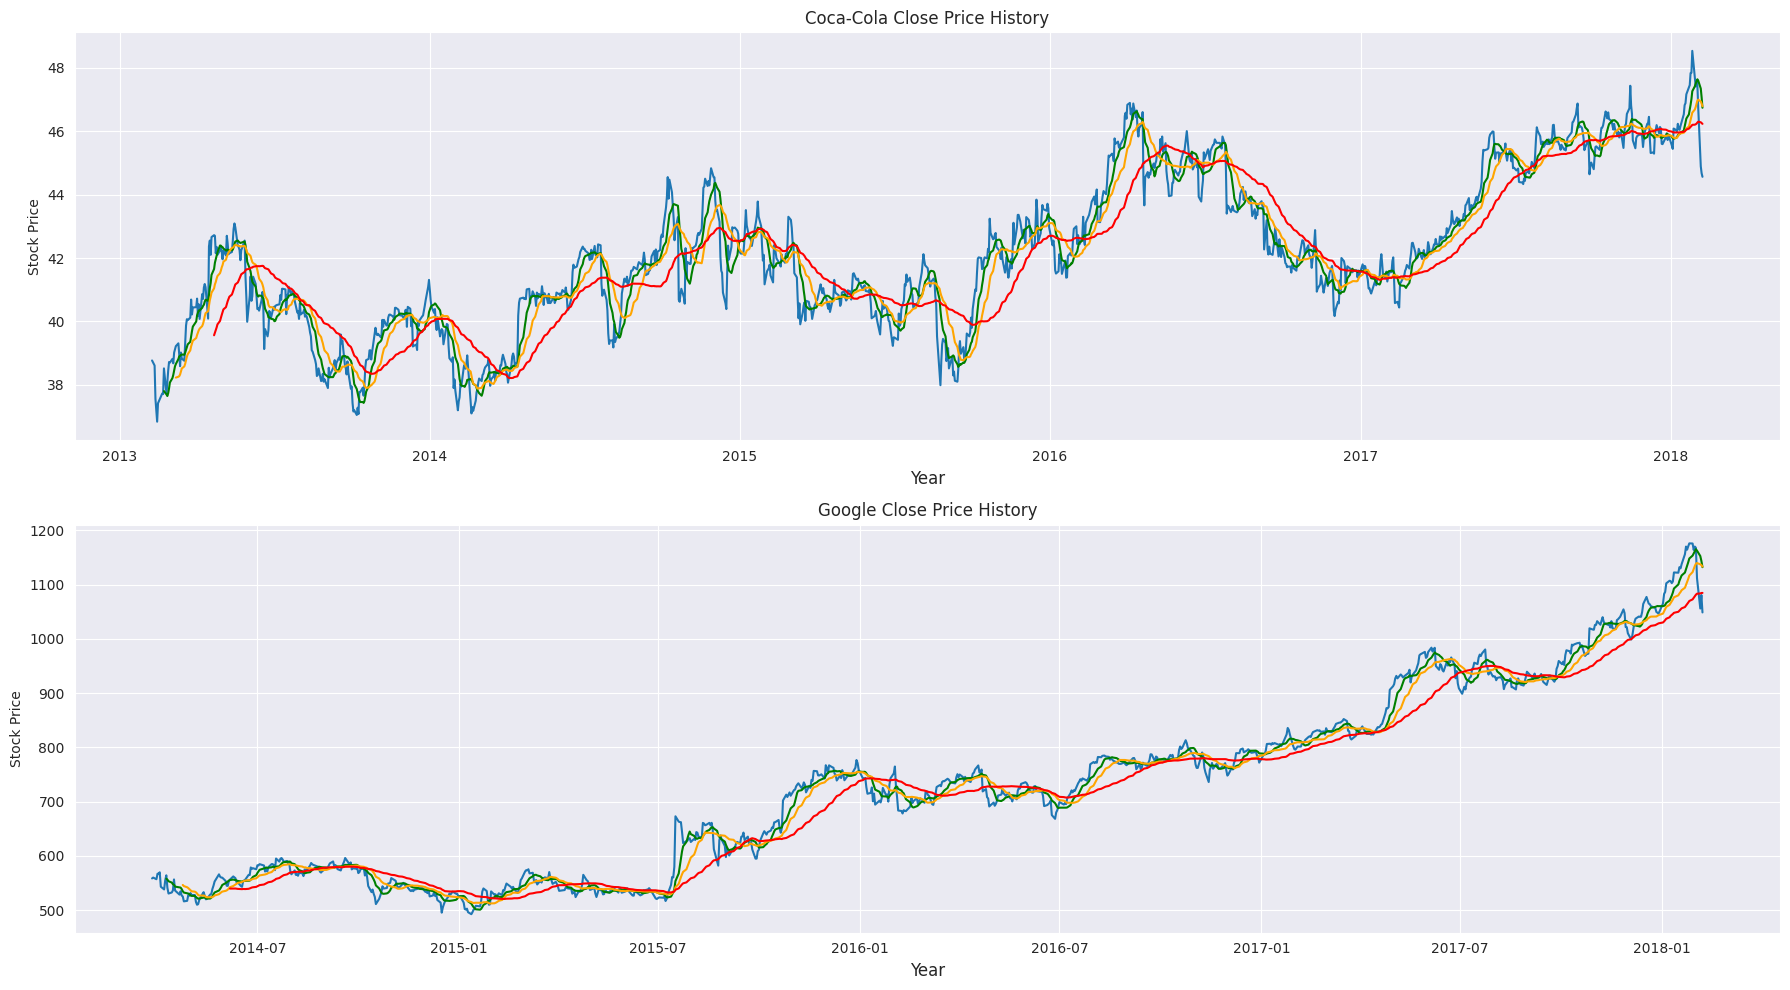

In [239]:
ko_df['10_ma'] = ko_df['close'].rolling(10).mean()
ko_df['20_ma'] = ko_df['close'].rolling(20).mean()
ko_df['50_ma'] = ko_df['close'].rolling(50).mean()

goog_df['10_ma'] = goog_df['close'].rolling(10).mean()
goog_df['20_ma'] = goog_df['close'].rolling(20).mean()
goog_df['50_ma'] = goog_df['close'].rolling(50).mean()

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(18, 10))
ax1.plot(ko_df['date'], ko_df['close'])
ax1.plot(ko_df['date'], ko_df['10_ma'], color='green')
ax1.plot(ko_df['date'], ko_df['20_ma'], color='orange')
ax1.plot(ko_df['date'], ko_df['50_ma'], color='red')
ax1.set_xlabel("Year", fontsize=12)
ax1.set_ylabel("Stock Price")
ax1.set_title("Coca-Cola Close Price History")

ax2.plot(goog_df['date'], goog_df['close'])
ax2.plot(goog_df['date'], goog_df['10_ma'], color='green')
ax2.plot(goog_df['date'], goog_df['20_ma'], color='orange')
ax2.plot(goog_df['date'], goog_df['50_ma'], color='red')
ax2.set_xlabel("Year", fontsize=12)
ax2.set_ylabel("Stock Price")
ax2.set_title("Google Close Price History")

plt.tight_layout()
plt.show()

# **Forecasting**

**LSTM**



In [240]:
# For Coca-Cola

ko_data = ko_df.filter(['date', 'close'])
ko_dataset = ko_data['close'].values
ko_training_data_len = int(np.ceil(len(ko_dataset) * 0.8))

scaler = MinMaxScaler(feature_range=(0, 1))
ko_scaled_dataset = scaler.fit_transform(ko_dataset.reshape(-1, 1))

ko_train_data = ko_scaled_dataset[0:ko_training_data_len, :]

ko_x_train = []
ko_y_train = []

for i in range(60, len(ko_train_data)):
  ko_x_train.append(ko_train_data[i-60:i, 0])
  ko_y_train.append(ko_train_data[i, 0])


ko_x_train, ko_y_train = np.array(ko_x_train), np.array(ko_y_train)
ko_x_train = np.reshape(ko_x_train, (ko_x_train.shape[0], ko_x_train.shape[1], 1))

In [241]:
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(ko_x_train.shape[1], 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(ko_x_train, ko_y_train, batch_size=1, epochs=5)

Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


948/948 ━━━━━━━━━━━━━━━━━━━━ 53s 52ms/step - loss: 0.0084
Epoch 2/5
948/948 ━━━━━━━━━━━━━━━━━━━━ 83s 54ms/step - loss: 0.0021
Epoch 3/5
948/948 ━━━━━━━━━━━━━━━━━━━━ 82s 54ms/step - loss: 0.0016
Epoch 4/5
948/948 ━━━━━━━━━━━━━━━━━━━━ 81s 53ms/step - loss: 0.0013
Epoch 5/5
948/948 ━━━━━━━━━━━━━━━━━━━━ 80s 51ms/step - loss: 0.0017


In [242]:
ko_test_data = ko_scaled_dataset[ko_training_data_len - 60:, :]
ko_x_test = []
ko_y_test = ko_dataset[ko_training_data_len:]

for i in range(60, len(ko_test_data)):
  ko_x_test.append(ko_test_data[i-60:i, 0])

ko_x_test = np.array(ko_x_test)
ko_x_test = np.reshape(ko_x_test, (ko_x_test.shape[0], ko_x_test.shape[1], 1))

ko_predictions = model.predict(ko_x_test)
ko_predictions = scaler.inverse_transform(ko_predictions)

ko_rmse = np.sqrt(np.mean(ko_predictions - ko_y_test) ** 2)

print(f"Coca-Cola Stocks trained under LSTM has an RMSE of {ko_rmse}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step
Coca-Cola Stocks trained under LSTM has an RMSE of 0.2192915246971098


In [243]:
# For Google

goog_data = goog_df.filter(['date', 'close'])
goog_dataset = goog_data['close'].values
goog_training_data_len = int(np.ceil(len(goog_dataset) * 0.8))

scaler = MinMaxScaler(feature_range=(0, 1))
goog_scaled_dataset = scaler.fit_transform(goog_dataset.reshape(-1, 1))

goog_train_data = goog_scaled_dataset[0:goog_training_data_len, :]

goog_x_train = []
goog_y_train = []

for i in range(60, len(goog_train_data)):
  goog_x_train.append(goog_train_data[i-60:i, 0])
  goog_y_train.append(goog_train_data[i, 0])


goog_x_train, goog_y_train = np.array(goog_x_train), np.array(goog_y_train)
goog_x_train = np.reshape(goog_x_train, (goog_x_train.shape[0], goog_x_train.shape[1], 1))

In [244]:
goog_model = Sequential()
goog_model.add(LSTM(64, return_sequences=True, input_shape=(goog_x_train.shape[1], 1)))
goog_model.add(LSTM(64, return_sequences=False))
goog_model.add(Dense(25))
goog_model.add(Dense(1))

goog_model.compile(optimizer='adam', loss='mean_squared_error')
goog_model.fit(goog_x_train, goog_y_train, batch_size=1, epochs=3)

Epoch 1/3


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


720/720 ━━━━━━━━━━━━━━━━━━━━ 23s 26ms/step - loss: 0.0044
Epoch 2/3
720/720 ━━━━━━━━━━━━━━━━━━━━ 22s 28ms/step - loss: 9.2647e-04
Epoch 3/3
720/720 ━━━━━━━━━━━━━━━━━━━━ 40s 27ms/step - loss: 5.4713e-04


In [245]:
goog_test_data = goog_scaled_dataset[goog_training_data_len - 60:, :]
goog_x_test = []
goog_y_test = goog_dataset[goog_training_data_len:]

for i in range(60, len(goog_test_data)):
  goog_x_test.append(goog_test_data[i-60:i, 0])

goog_x_test = np.array(goog_x_test)
goog_x_x_test = np.reshape(goog_x_test, (goog_x_test.shape[0], goog_x_test.shape[1], 1))

goog_predictions = goog_model.predict(goog_x_test)
goog_predictions = scaler.inverse_transform(goog_predictions)

goog_rmse = np.sqrt(np.mean(goog_predictions - goog_y_test) ** 2)

print(f"Google stocks trained under LSTM has an RMSE of {goog_rmse}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step
Google stocks trained under LSTM has an RMSE of 61.73712417367787


**Forecast Visualization**

/tmp/ipython-input-246-1215409603.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ko_valid['forecast'] = ko_predictions
/tmp/ipython-input-246-1215409603.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  goog_valid['forecast'] = goog_predictions


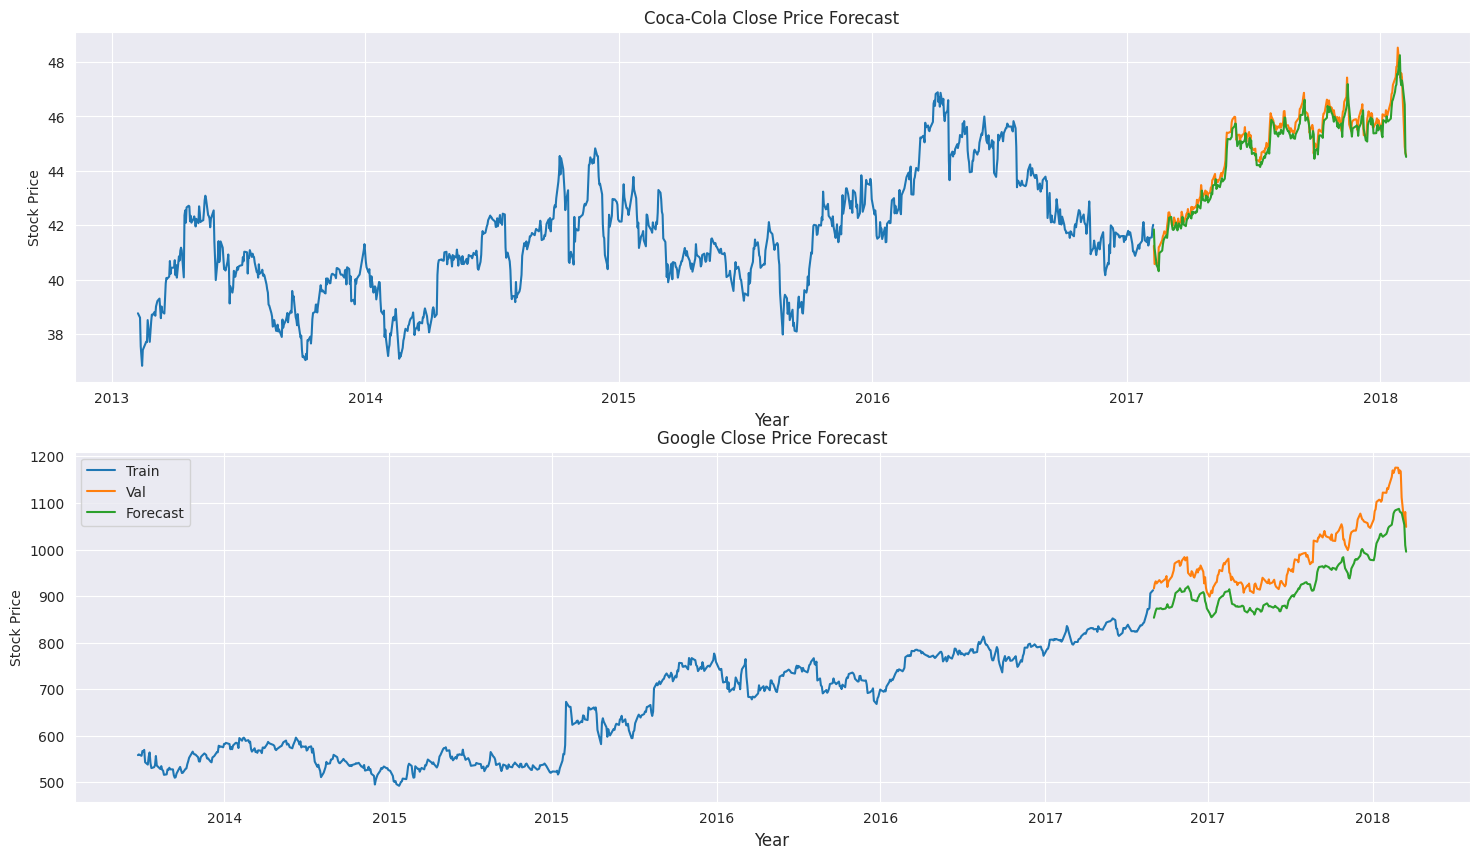

In [246]:
ko_train = ko_df[:ko_training_data_len]
ko_valid = ko_df[ko_training_data_len:]
ko_valid['forecast'] = ko_predictions

goog_train = goog_df[:goog_training_data_len]
goog_valid = goog_df[goog_training_data_len:]
goog_valid['forecast'] = goog_predictions


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(18, 10))
ax1.plot(ko_train['date'], ko_train['close'])
ax1.plot(ko_valid['date'], ko_valid[['close', 'forecast']])
ax1.set_xlabel("Year", fontsize=12)
ax1.set_ylabel("Stock Price")
ax1.set_title("Coca-Cola Close Price Forecast")
ax1.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y'))


ax2.plot(goog_train['date'], goog_train['close'])
ax2.plot(goog_valid['date'], goog_valid[['close', 'forecast']])
ax2.set_xlabel("Year", fontsize=12)
ax2.set_ylabel("Stock Price")
ax2.set_title("Google Close Price Forecast")
ax2.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y'))


plt.legend(['Train', 'Val', 'Forecast'])
plt.show()